In [ ]:
import cv2
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#Saved Model Directory
model = load_model('/content/drive/MyDrive/ML Project/model')

Mounted at /content/drive


In [ ]:
!pip install Autoscraper

## Recognition 

In [ ]:
def add_border(img,bordersize):
    border = cv2.copyMakeBorder(
    img,
    top=0,
    bottom=0,
    left=bordersize,
    right=bordersize,
    borderType=cv2.BORDER_CONSTANT,
    value=[255, 255,255]
    )
    return border.copy()

In [ ]:
classes = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ()+'  
def predict_char(x1,x2,y1,y2,img):
  img = img[y1:y2,x1:x2]
  img = add_border(img,10)
  border = cv2.resize(img,(28,28),interpolation = cv2.INTER_AREA)
  cv2_imshow(border)
 # img = cv2.resize(img,(28,28),cv2.INTER_AREA)
  #cv2_imshow(img)
  arr = np.array(border)
  arr = arr.reshape(-1,28,28,1)
  index = np.argmax(model.predict(arr))
  return classes[index]

In [ ]:
def find_edges(edge,axs):
    sum = np.sum(edge, axis=axs)
    sum = sum != 0
    changes = np.logical_xor(sum[1:], sum[:-1])
    return np.nonzero(changes)[0]

In [ ]:
plt.figure(figsize = (15,15))
def find_character(imag,org):
    shap = imag.shape[:2]
    size = 3
    imag = cv2.copyMakeBorder(imag,size,size,size,size,cv2.BORDER_CONSTANT,value = (0,0,0))
    imag = cv2.resize(imag,(6*shap[0],4*shap[1]),interpolation = cv2.INTER_AREA)
    imag = cv2.bitwise_not(imag)
    vert_edges = cv2.Canny(imag, 200, 255)
    vert_loc_pts = find_edges(vert_edges.copy(),0)

    char_location = []
    char = ''
    for idx in range(0,len(vert_loc_pts),2):
        x1 = vert_loc_pts[idx]+1
        x2 = vert_loc_pts[idx+1]+1
        vert_img = imag[:, x1:x2]
        hrz_edges = cv2.Canny(vert_img,200,255)
        hrz_loc_pts = find_edges(hrz_edges.copy(),1)
        y1 = hrz_loc_pts[0]
        y2 = hrz_loc_pts[1]
        space = 7
        char += predict_char(x1-space,x2+space,y1-space,y2+space,imag.copy())
       # cv2.rectangle(org, (x1, y1), (x2, y2), (0, 255 , 100), thickness=1)
    #cv2_imshow(org)
    return char

<Figure size 1080x1080 with 0 Axes>

## Searching products
(Make sure your Internet is on)

In [ ]:
from autoscraper import AutoScraper

url = 'https://chemequations.com/en/?s='

search1 = 'naoh+%2B+HCl'

content_ans = ['NaOH (aq) + HCl (aq) → H2O (l) + NaCl (aq)']
content_detail = ['This is an acid-base reaction (neutralization): NaOH is a base, HCl is an acid.']

scraper_ans = AutoScraper()
scraper_detail = AutoScraper()

result_ans = scraper_ans.build(url+search1,content_ans)
result_detail = scraper_detail.build(url+search1,content_detail)

In [ ]:
def find_result(reaction):
  search = reaction.lower().replace('+','+%2B+')
  try:
    result_ans = scraper_ans.get_result_similar(url+search)
    result_detail = scraper_detail.get_result_similar(url+search)
    return result_ans, result_detail
  except:
    return 'Soory, Answer Not Found...',''

## Detection

In [ ]:
def get_contour_precedence(contour, cols):
    tolerance_factor = 61
    origin = cv2.boundingRect(contour)
    return ((origin[1] // tolerance_factor) * tolerance_factor) * cols + origin[0]

In [ ]:
plt.figure(figsize = (15,15))
def find_reaction(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
    dilation = cv2.dilate(thresh1, rect_kernel, iterations=1)
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                           cv2.CHAIN_APPROX_NONE)
    im2 = img.copy()
    contours.sort(key=lambda x: get_contour_precedence(x, thresh1.shape[1]))
    print('Original Image:')
    cv2_imshow(im2)
    print('\nDetected Characters:')
    reactant = ''
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        #print(area)
        if area < 400:
            continue
        rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0,100,255), 2)
        temp = cv2.bitwise_not(thresh1[y:y+h,x:x+w])
        reactant += find_character(thresh1[y:y+h,x:x+w],im2)
    print('\nText Detected: ')
    cv2_imshow(im2)
    print(f'\nReactants: {reactant}',end = '\n\n')
    reaction, details = find_result(reactant)
    try:
      print(f'The complete balanced reaction...\n>>> {reaction[0]}')
      print(f'\nReaction Details...\n>>> {details[0]}\n\n')
    except IndexError:
      print('!! Answer Not Found !!\n\n')    

<Figure size 1080x1080 with 0 Axes>

## Testing Images
(Change path according to your Image directory)

In [ ]:
# Test Image Directory
path = '/content/drive/MyDrive/ML Project/Final_Images'

Original Image:


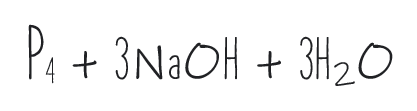


Detected Characters:



Text Detected: 


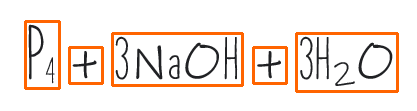


Reactants: P4+3NAOH+3H2O

The complete balanced reaction...
>>> P4 + 3 NaOH + 3 H2O → PH3 + 3 NaH2PO2

Reaction Details...
>>> This is an oxidation-reduction (redox) reaction:3 P0 - 3 e- → 3 PI (oxidation)P0 + 3 e- → P-III (reduction)P4 is both an oxidizing and a reducing agent (disproportionation (dismutation)).




In [ ]:
find_reaction(os.path.join(path,'final 1.png'))

Original Image:


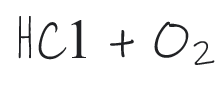


Detected Characters:



Text Detected: 


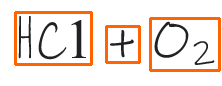


Reactants: HCL+O2

The complete balanced reaction...
>>> 4 HCl (g) + O2 (g) → 2 H2O (l) + 2 Cl2 (g)

Reaction Details...
>>> This is an oxidation-reduction (redox) reaction:4 Cl-I - 4 e- → 4 Cl0 (oxidation)2 O0 + 4 e- → 2 O-II (reduction)HCl is a reducing agent, O2 is an oxidizing agent.




In [ ]:
find_reaction(os.path.join(path,'final 6.png'))

Original Image:


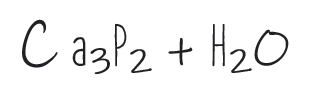


Detected Characters:



Text Detected: 


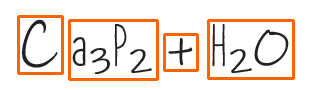


Reactants: CA3P2+H2O

The complete balanced reaction...
>>> Ca3P2 + 6 H2O → 3 Ca(OH)2 + 2 PH3

Reaction Details...
>>> Reactants:Ca3P2 – Calcium phosphide Other names: Photophor , CP , Polythanol , Tricalcium diphosphide Appearance: Red-brown crystalline powder or grey lumps ; Red-brown crystalline powder or grey lumps H2O – Water, oxidane Other names: Water (H2O) , Hydrogen hydroxide (HH or HOH) , Hydrogen oxide ... show moreDihydrogen monoxide (DHMO) (systematic name) , Hydrogen monoxide , Dihydrogen oxide , Hydric acid , Hydrohydroxic acid , Hydroxic acid , Hydrol , Μ-oxido dihydrogen , Κ1-hydroxyl hydrogen(0) show lessAppearance: White crystalline solid, almost colorless liquid with a hint of blue, colorless gas Products:Ca(OH)2 – Calcium hydroxide Other names: {{ubl , Slaked lime , Calcium hydrate ... show moreCaustic lime , Hydrated lime , Ca(OH)2 , Hydralime , Calcium dihydroxide show lessAppearance: White powder ; Colourless crystals or white powder ; White, odorless powder. [

In [ ]:
find_reaction(os.path.join(path,'final 3.png'))

Original Image:


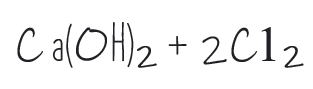


Detected Characters:



Text Detected: 


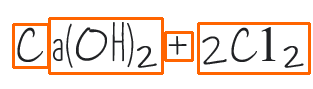


Reactants: CA(OH)2+2CL2

The complete balanced reaction...
>>> 6 Ca(OH)2 (s) + 6 Cl2 (g) → 6 H2O (l) + 5 CaCl2 (aq) + Ca(ClO3)2 (aq)

Reaction Details...
>>> This is an oxidation-reduction (redox) reaction:10 Cl0 + 10 e- → 10 Cl-I (reduction)2 Cl0 - 10 e- → 2 ClV (oxidation)Cl2 is both an oxidizing and a reducing agent (disproportionation (dismutation)).




In [ ]:
find_reaction(os.path.join(path,'final 8.png'))